# 2nd Order Problems
Consider the computational domain $\Omega = [0,L] \times [0,B]$ and the Diffusion-Convection equation with ho-mogeneous right hand side:

$$
\newcommand{\part}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\vec}[2]{\begin{pmatrix} #1\\ #2 \end{pmatrix}}
\begin{split}
-\nabla \cdot (K\nabla u ) + \beta \cdot \nabla u & = 0\text{, in $\Omega$} \\
\part{u}{y}(x,0) & = 0 \text{, x } \in [0,L] \\
\part{u}{y}(x,B) & = 0 \text{, x } \in [0,L] \\
u(0,y) & = 0 \text{, y } \in [0,B] \\
u(L,y) & = 1 \text{, y } \in [0,B]
\end{split}
$$

The parameter $K$ is the scalar diffusion coefficient and $\beta = \vec{\beta_1}{\beta_2}$ the convection velocity field.

* **Continous variational formulation**

$$
\int_{\Omega}(\nabla v\cdot (K\nabla u)+v\beta\cdot u) d\Omega = 0
% \int_{\Omega}(\nabla v\cdot (K\nabla u)+v\beta\cdot u + \sigma u v) d\Omega = \int_{\Omega}(f v)d\Omega
% esse trecho de cima é referente a este problema? eu acho que não, convém checar
$$

O termo $\int_{\partial\Omega}(v \textbf{n}\cdot (K\nabla u))d\Gamma$ that would be at the right side of the equation is null because on $\Gamma_{N}$ it values 0, and on $\Gamma_{D}$ we put 0 because we have no information about the derivative in normal direction.


<!-- Making $\kappa = 1$, $f = 8\pi^2 cos(2\pi x_1)cos(2\pi x_2)$, the exact solution reads

$$
u(x) = cos(2\pi x_1)cos(2\pi x_2)
$$

The solution $u_h$ is sought in a finite dimensional space $V_h \subset H^1(\Omega)$, made up of polynomial functions of degree k. In the variational formulation one looks for $u_h in V_h$ such that
$$
\int_{\Omega} \nabla u_h \cdot \nabla v_h dx \int_{\Omega} f v_h dx
$$

In the following, the problem is solved, in different settings (with different mesh refinements and different $V_h$s), and then it is computed the errors L2 and H1 and the runtime of each running, as an effort to develop a way to determine which setting to use in a situation. -->

In [1]:
## Importing libraries

from fenics import *
from mshr import *
import numpy
from datetime import datetime
import csv
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

### User defined parameters
#### Set the following parameters according to your problem

In [2]:
def advection_diffusion(beta, 
                        k,
                        order,
                        mesh_refinement,
                        space_dim = 2,
                        L = 1.0,
                        B = 1.0,
                        r_border_refinements = 0,
                        fileio = 'pvd',
                        dir_ = './results'
                       ):
    #fileio = 'pvd'
    #dir_ = './results'

    if not os.path.exists(dir_):
        os.mkdir(dir_)

    if(space_dim == 2):
       domain = Rectangle(Point(0.0,0.0), Point(L,B))
    else:
       sys.exit("space_dim.eq.3 not implemented")

    # Thermal conductivity
    #k = 1.0
    kappa = Constant(k)

    # Convection velocity field
    beta = Constant(beta)

    # Order and refinement
    #order = 3
    #mesh_refinement = 40

    #### IO setup
    Pk = FiniteElement("Lagrange", 'triangle', order)

    ufile_pvd  = File(dir_+f'/temperatureO{order}mr{mesh_refinement}br{r_border_refinements}.pvd')
    domfile_pvd = File(dir_+f"/auxfuncO{order}mr{mesh_refinement}br{r_border_refinements}.pvd")

    # Order of finite elements space
    startTime = datetime.now()
    print(f'\n   ::> Begin computations for order {order} and refinement {mesh_refinement}')

    #### Mesh generation
    mesh = generate_mesh(domain, mesh_refinement)
    
        
    ### Dirichlet boundary conditions
    class Left(SubDomain):
        def inside(self, x, on_boundary):
            return (on_boundary and near(x[0],0))
    class Right(SubDomain):
        def inside(self, x, on_boundary):
            return (on_boundary and near(x[0],L))

    left    = Left()
    right   = Right()
    
    # Number of refinements
    if r_border_refinements > 0:
        for i in range(r_border_refinements):
            edge_markers = MeshFunction('bool', mesh, mesh.topology().dim()-1)
            right.mark(edge_markers, True)

            mesh = refine(mesh, edge_markers)
            #mesh = mesh.child()
    
    print("    |-Mesh done")
    print("    |--Number of vertices = "+str(mesh.num_vertices()))
    print("    |--Number of cells = "+str(mesh.num_cells()))
    print("    |--Cell size hmax,hmin = %.3g %.3g" % (mesh.hmax(), mesh.hmin()))

    
    # Finite element space
    W = FunctionSpace(mesh, Pk)
    print("    |--Total number of unknowns = %d" % (W.dim()))
    
    
    ### Variational formulation: Poisson problem
    u = TrialFunction(W)
    v = TestFunction(W)

    funcdom = MeshFunction("size_t", mesh, mesh.topology().dim(), mesh.domains())
    dx = Measure("dx")(subdomain_data=funcdom)

    f = Constant(0)
    a = inner(kappa*grad(u), grad(v))*dx + v*inner(beta,grad(u))*dx
    LL = f*v*dx


    bcleft  = DirichletBC(W, Constant(0), left)
    bcright = DirichletBC(W, Constant(1), right)

    
    ### Solution
    w = Function(W)

    # solver.solve()
    solve(a == LL, w, [bcleft, bcright])

    ####### IO
    ufile_pvd << w
    domfile_pvd << funcdom
    
    #plt.figure(figsize=(10,10))
    #plot(mesh,linewidth=.1)
    #c = plot(w, wireframe=True, title=f'Solution')
    #plt.colorbar(c)
    #plt.show()
    
    return w, mesh

### Solutions for $\kappa \in {10,1,.1,.01,.001}$

In [3]:
ks = [10, 1, .1, .01, .001]
solutions = [advection_diffusion(beta = (1,0), k = k, order = 3, mesh_refinement = 40, L = 2) 
             for k in ks]


   ::> Begin computations for order 3 and refinement 40
    |-Mesh done
    |--Number of vertices = 2063
    |--Number of cells = 3932
    |--Cell size hmax,hmin = 0.0503 0.0262
    |--Total number of unknowns = 17983

   ::> Begin computations for order 3 and refinement 40
    |-Mesh done
    |--Number of vertices = 2063
    |--Number of cells = 3932
    |--Cell size hmax,hmin = 0.0503 0.0262
    |--Total number of unknowns = 17983

   ::> Begin computations for order 3 and refinement 40
    |-Mesh done
    |--Number of vertices = 2063
    |--Number of cells = 3932
    |--Cell size hmax,hmin = 0.0503 0.0262
    |--Total number of unknowns = 17983

   ::> Begin computations for order 3 and refinement 40
    |-Mesh done
    |--Number of vertices = 2063
    |--Number of cells = 3932
    |--Cell size hmax,hmin = 0.0503 0.0262
    |--Total number of unknowns = 17983

   ::> Begin computations for order 3 and refinement 40
    |-Mesh done
    |--Number of vertices = 2063
    |--Number of c

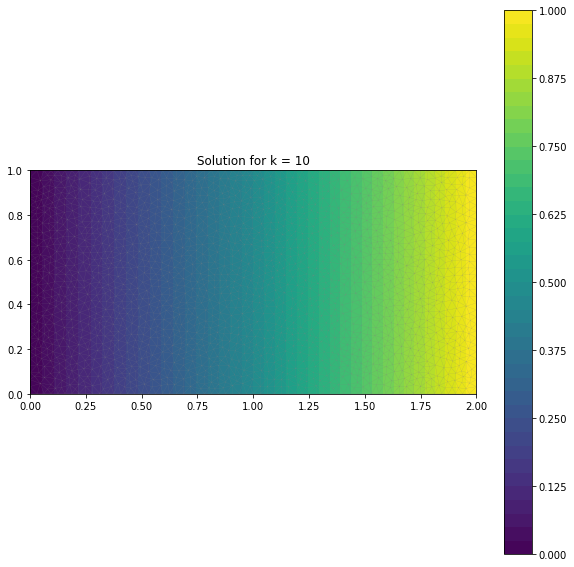

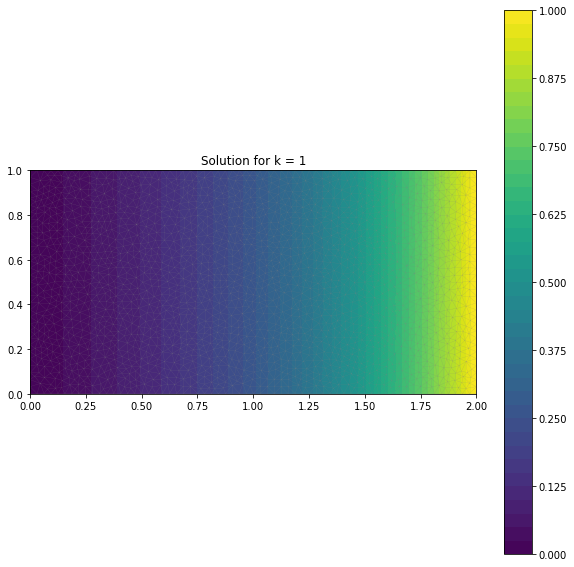

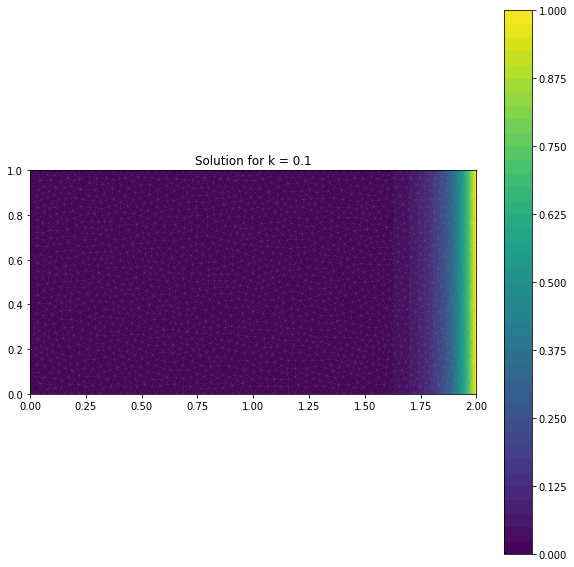

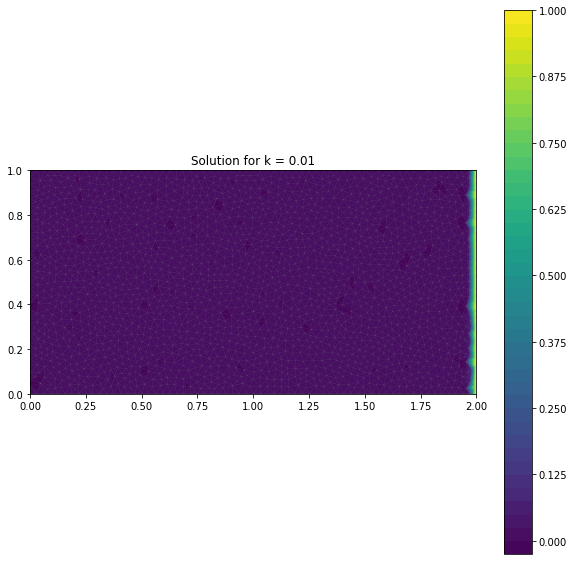

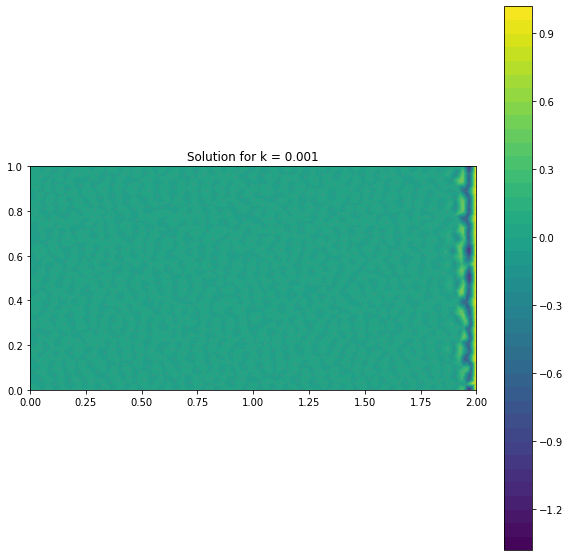

In [4]:
for ((w, mesh), k) in zip(solutions, ks):
    plt.figure(figsize=(10,10))
    plot(mesh,linewidth=.1)
    c = plot(w, wireframe=True, title=f"Solution for k = {k}")
    plt.colorbar(c)
    plt.show()

### Uniform mesh refinements for $\kappa = .01$


   ::> Begin computations for order 3 and refinement 40
    |-Mesh done
    |--Number of vertices = 2063
    |--Number of cells = 3932
    |--Cell size hmax,hmin = 0.0503 0.0262
    |--Total number of unknowns = 17983

   ::> Begin computations for order 3 and refinement 80
    |-Mesh done
    |--Number of vertices = 8131
    |--Number of cells = 15876
    |--Cell size hmax,hmin = 0.0252 0.0129
    |--Total number of unknowns = 72019

   ::> Begin computations for order 3 and refinement 160
    |-Mesh done
    |--Number of vertices = 32099
    |--Number of cells = 63428
    |--Cell size hmax,hmin = 0.0126 0.00637
    |--Total number of unknowns = 286579

   ::> Begin computations for order 3 and refinement 320
    |-Mesh done
    |--Number of vertices = 127460
    |--Number of cells = 253382
    |--Cell size hmax,hmin = 0.00629 0.00319
    |--Total number of unknowns = 1142524


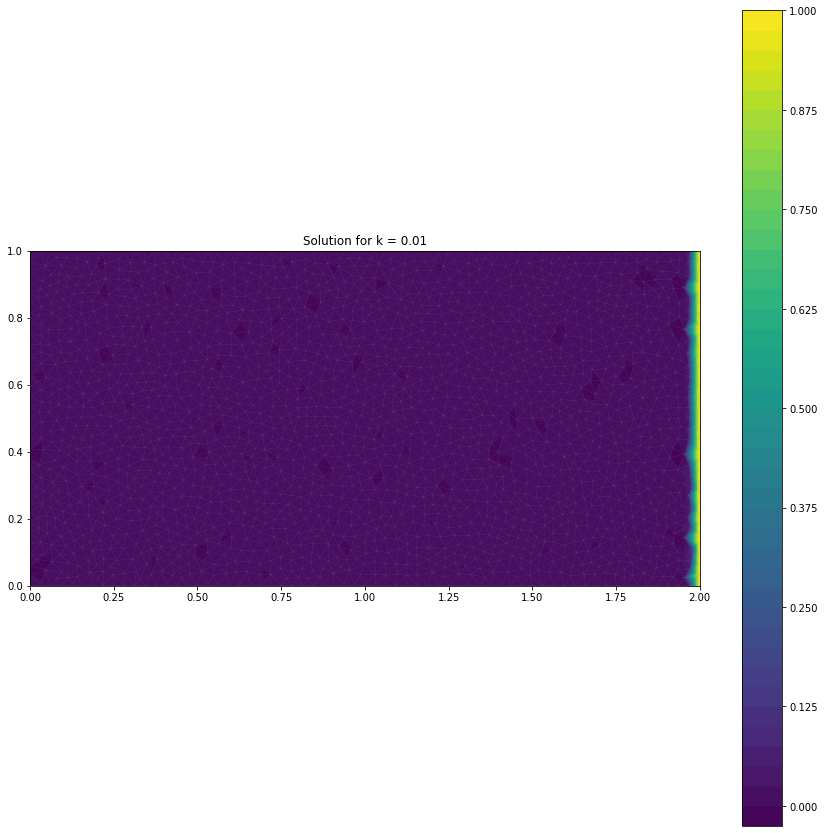

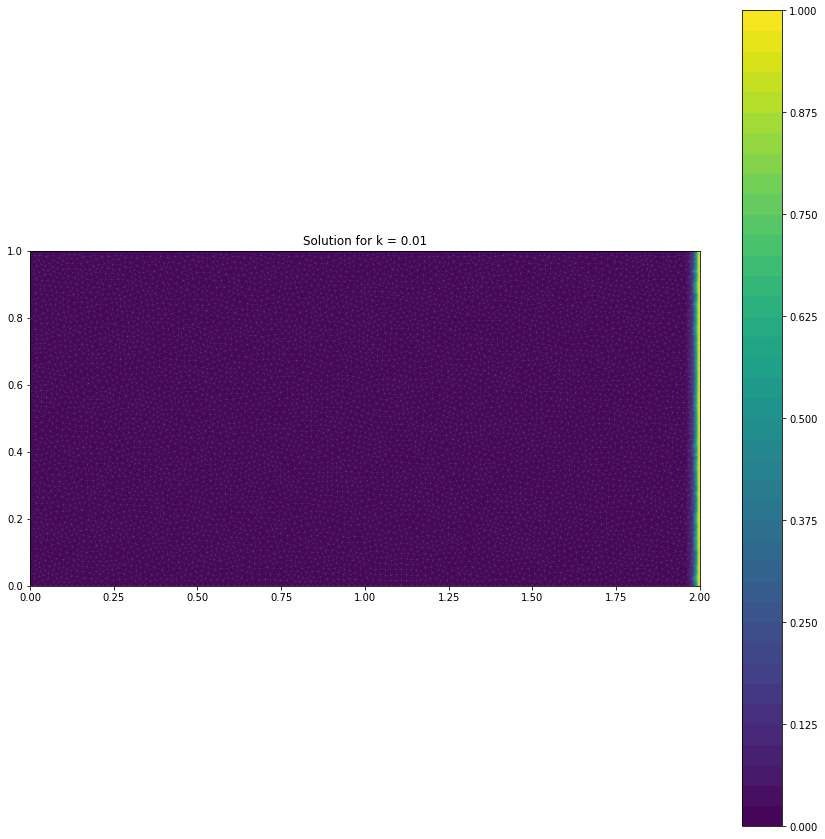

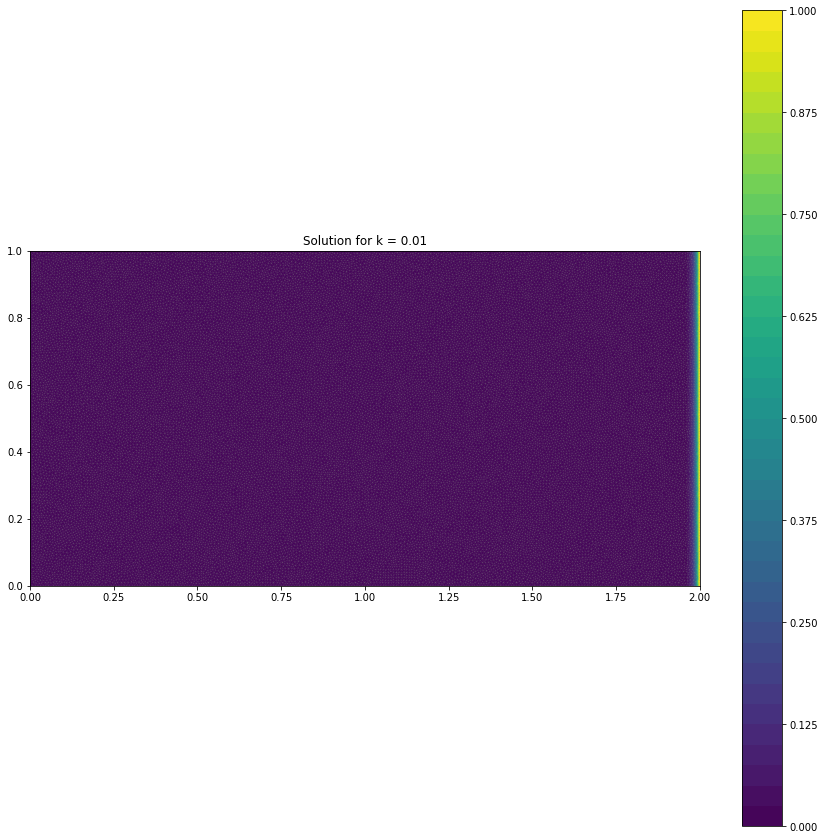

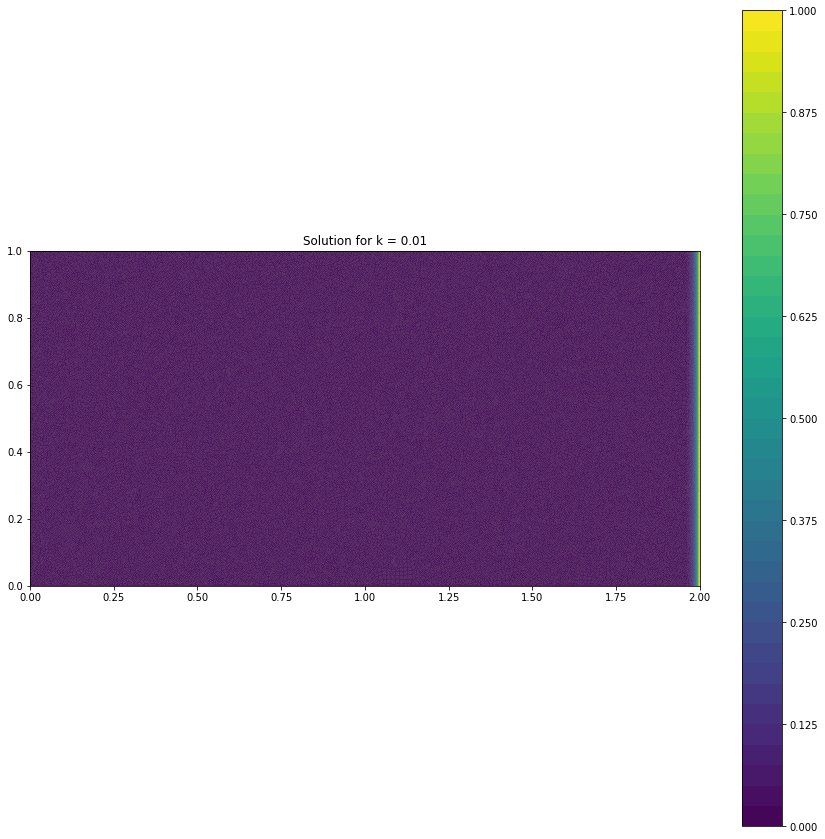

In [5]:
k = .01

solutions = [advection_diffusion(beta = (1,0), k = k, order = 3, mesh_refinement = mesh_refinement, L = 2) 
             for mesh_refinement in [40, 80, 160, 320]]

for (w, mesh) in solutions:
    plt.figure(figsize=(15,15))
    plot(mesh,linewidth=.1)
    c = plot(w, wireframe=True, title=f'Solution for k = {k}')
    plt.colorbar(c)
    plt.show()

### Local mesh refinement on rightmost boundary


   ::> Begin computations for order 3 and refinement 80
    |-Mesh done
    |--Number of vertices = 171795
    |--Number of cells = 277714
    |--Cell size hmax,hmin = 0.0252 1.54e-05
    |--Total number of unknowns = 1348525


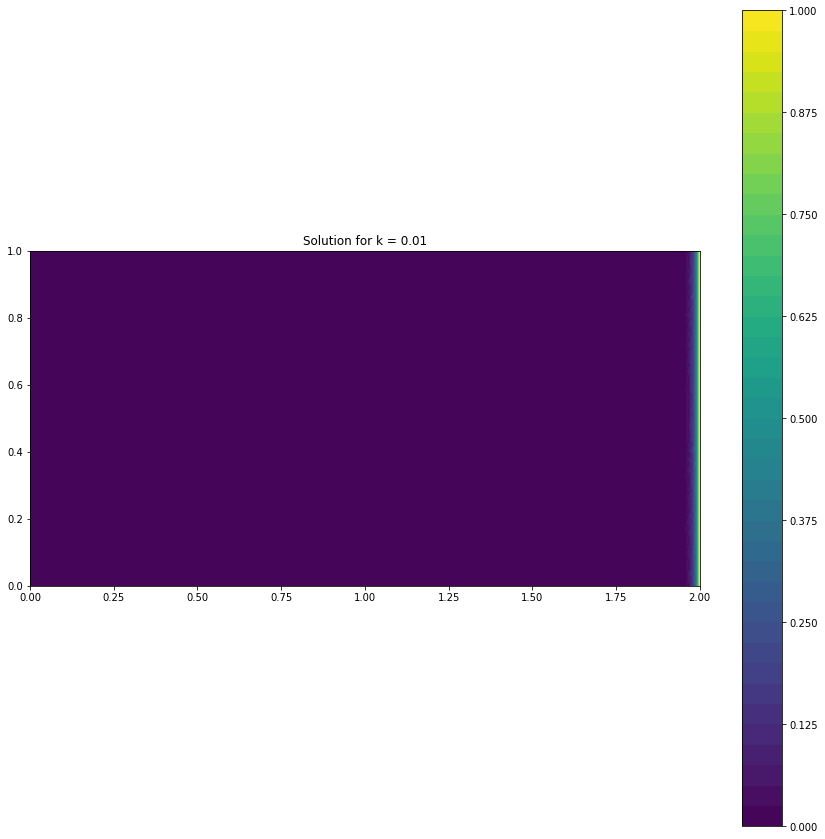

In [6]:
k = .01
(w, mesh) = advection_diffusion(beta = (1,0), 
                                k = k, 
                                order = 3, 
                                mesh_refinement = 80, 
                                L = 2, 
                                r_border_refinements = 10) 

plt.figure(figsize=(15,15))
#plot(mesh,linewidth=.1)
c = plot(w, wireframe=True, title=f'Solution for k = {k}')
plt.colorbar(c)
plt.show()


   ::> Begin computations for order 3 and refinement 160
    |-Mesh done
    |--Number of vertices = 113642
    |--Number of cells = 193860
    |--Cell size hmax,hmin = 0.0126 3.25e-05
    |--Total number of unknowns = 922504


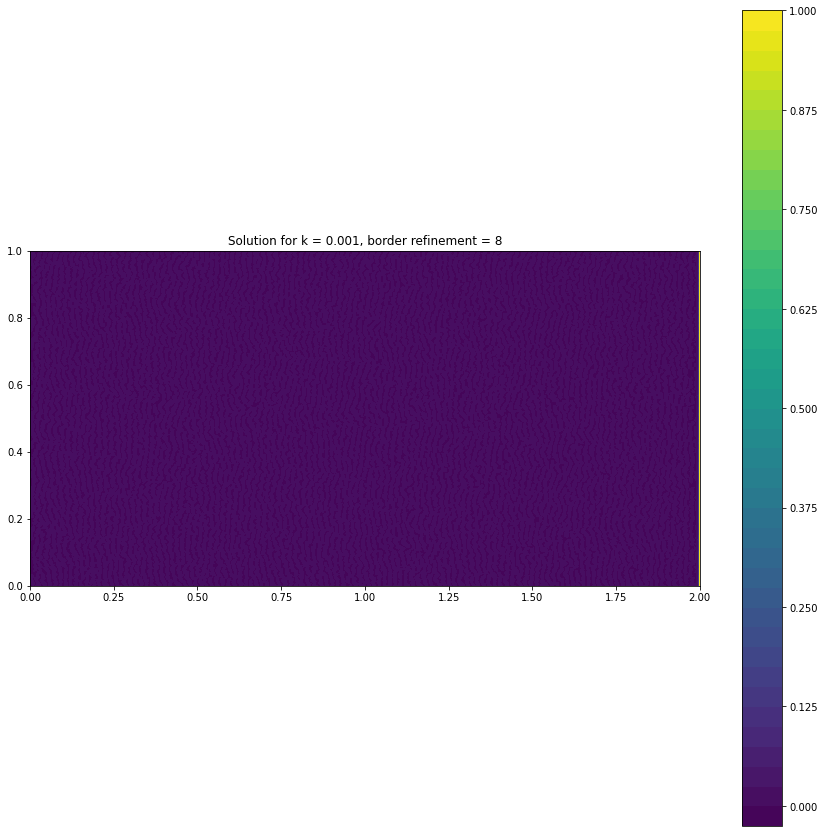

In [15]:
k = .001
r_border_refinements = 8

(w, mesh) = advection_diffusion(beta = (1,0), 
                                k = k, 
                                order = 3, 
                                mesh_refinement = 160, 
                                L = 2, 
                                r_border_refinements = r_border_refinements) 

plt.figure(figsize=(15,15))
#plot(mesh,linewidth=.1)
c = plot(w, wireframe=True, title=f'Solution for k = {k}, border refinement = {r_border_refinements}')
plt.colorbar(c)
plt.show()